# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [27]:
#Import all the required libraries
import pandas as pd
import numpy as np
import glob
import time
import os

import tensorflow as tf

import PIL
from PIL import Image
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [28]:
#from google.colab import drive

is_colab=False
if is_colab:
    drive.mount('/content/drive')

In [29]:
#Data files and folders
if is_colab:
    images_folder = '/content/drive/MyDrive/images/'
    captions_filename = '/content/drive/MyDrive/captions.txt'
else:
    images_folder = 'images/'
    captions_filename = 'captions.txt'

In [30]:
#Import the dataset and read the image into a seperate variable
all_imgs = glob.glob(images_folder + '*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [31]:
#Function to load document in a dataframe
def load_doc(filename, colnames):
    df=pd.read_csv(filename, names=colnames, header=0)
    return df

#Import the dataset and read the text file into a seperate variable
col_names = ['ID','Captions']
captions_df = load_doc(captions_filename, col_names)
captions_df.head(10)

,ID,Captions
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [32]:
#Function to get all captions
def get_all_captions(captions_dataframe):
    return captions_dataframe['Captions'].values.tolist()

#Function to plot image followed by it's captions
def plot_image_captions(captions_dataframe):
    plt.figure(figsize=(8, 6))
    plt.subplot(1,2,1)
    imgname = captions_dataframe['Path'].sample().values.tolist()[0]
    img = PIL.Image.open(imgname)
    plt.imshow(img.resize((512,512)))
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.text(0,0.5,("\n").join(captions_dataframe[captions_dataframe['Path']==imgname]['Captions'].values.tolist()), fontsize=16)
    plt.axis("off")
    plt.show()

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [33]:
#Since we already picked image ids and captions in a dataframe, we will just add path to that dataframe
captions_df['Path'] = images_folder+captions_df['ID'] #all images reside in same folder so this works for our data
captions_df
captions_df.head(10)

,ID,Captions,Path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,images/1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,images/1000268201_693b08cb0e.jpg
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,images/1000268201_693b08cb0e.jpg
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,images/1000268201_693b08cb0e.jpg
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,images/1000268201_693b08cb0e.jpg
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting,images/1001773457_577c3a7d70.jpg
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...,images/1001773457_577c3a7d70.jpg
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...,images/1001773457_577c3a7d70.jpg
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...,images/1001773457_577c3a7d70.jpg
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .,images/1001773457_577c3a7d70.jpg


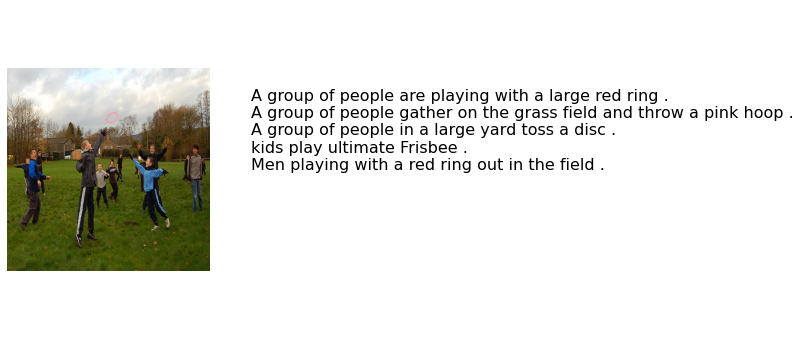

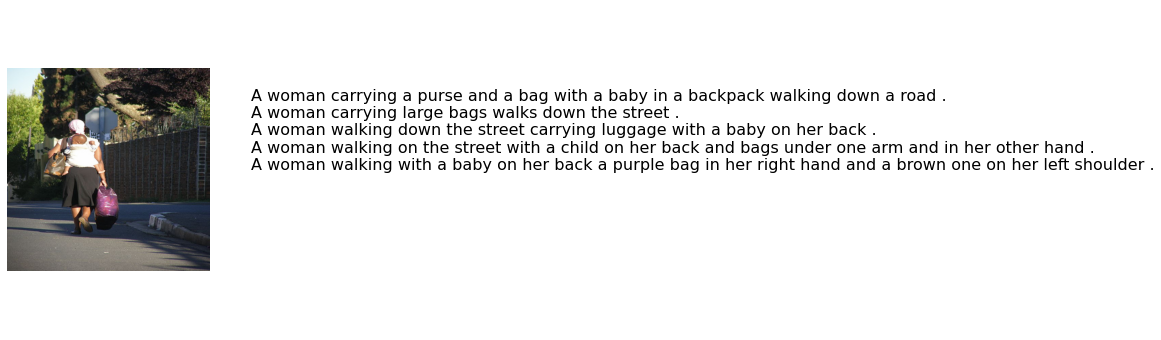

In [34]:
#Visualise both the images & text present in the dataset
plot_image_captions(captions_df)
plot_image_captions(captions_df)

In [35]:
#Create a list which contains all the captions
annotations=get_all_captions(captions_df)
#add the <start> & <end> token to all those captions as well
annotations = ['<start> '+cap+' <end>' for cap in annotations]

#Create a list which contains all the path to the images
all_img_path=captions_df['Path'].values.tolist()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(set(all_img_path))))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [36]:
# Print one caption to check for start and end tokens
annotations[0]

'<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>'

In [37]:
# Create the vocabulary & the counter for the captions
vocabulary= [word for cap in captions_df['Captions'] for word in cap.split(" ")]
val_count=Counter(vocabulary)
val_count

Counter({'A': 22667,
         'child': 1477,
         'in': 18962,
         'a': 40319,
         'pink': 734,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1945,
         'entry': 1,
         'way': 50,
         '.': 36577,
         'girl': 3218,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7984,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 772,
         'on': 10730,
         'road': 388,
         'white': 3876,
         'brown': 2475,
         'spots': 29,
         'staring'

In [38]:
#Visualise the top 30 occuring words in the captions
val_count.most_common(30)

[('a', 40319),
 ('.', 36577),
 ('A', 22667),
 ('in', 18962),
 ('the', 15328),
 ('on', 10730),
 ('is', 9345),
 ('and', 8850),
 ('dog', 7984),
 ('with', 7760),
 ('man', 6829),
 ('of', 6712),
 ('Two', 4365),
 ('white', 3876),
 ('black', 3696),
 ('are', 3503),
 ('boy', 3442),
 (',', 3232),
 ('woman', 3228),
 ('girl', 3218),
 ('to', 3173),
 ('The', 3089),
 ('wearing', 3061),
 ('at', 2904),
 ('water', 2778),
 ('red', 2660),
 ('brown', 2475),
 ('people', 2446),
 ('young', 2432),
 ('his', 2357)]

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [39]:
# create the tokenizer
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(annotations)

In [40]:
# Create word-to-index and index-to-word mappings.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [41]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('<end>', 40455),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('color

In [42]:
# Pad each vector to the max_length of the captions and store it to a vairable
annotations_seq = tokenizer.texts_to_sequences(annotations)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(annotations_seq, padding='post')
max_length = max(len(s) for s in annotations_seq)
print("Max caption length is :" + str(max_length))
print("The shape of Caption vector is :" + str(cap_vector.shape))

Max caption length is :39
The shape of Caption vector is :(40455, 39)


In [43]:
# Check longest sentence
idx_nbr = [x[0] for x in [i for i in enumerate([len(s) for s in annotations_seq])] if x[1]==39][0]
annotations[idx_nbr]

'<start> An African-American man wearing a green sweatshirt and blue vest is holding up 2 dollar bills in front of his face , while standing on a busy sidewalk in front of a group of men playing instruments . <end>'

In [44]:
# Notice 0 padded to cap vector
cap_vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0]])

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [45]:
#write your code here for creating the function. This function should return images & their path
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299,299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, image_path

In [46]:
#write your code here to create the dataset consisting of image paths
img_dataset = tf.data.Dataset.from_tensor_slices(all_img_path)

In [47]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
img_dataset = img_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)
img_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [48]:
#Chcek image dataset for first batch
for img, path in img_dataset:
    print(path)
    break

tf.Tensor(
[b'images/1000268201_693b08cb0e.jpg' b'images/1000268201_693b08cb0e.jpg'
 b'images/1000268201_693b08cb0e.jpg' b'images/1000268201_693b08cb0e.jpg'
 b'images/1000268201_693b08cb0e.jpg' b'images/1001773457_577c3a7d70.jpg'
 b'images/1001773457_577c3a7d70.jpg' b'images/1001773457_577c3a7d70.jpg'
 b'images/1001773457_577c3a7d70.jpg' b'images/1001773457_577c3a7d70.jpg'
 b'images/1002674143_1b742ab4b8.jpg' b'images/1002674143_1b742ab4b8.jpg'
 b'images/1002674143_1b742ab4b8.jpg' b'images/1002674143_1b742ab4b8.jpg'
 b'images/1002674143_1b742ab4b8.jpg' b'images/1003163366_44323f5815.jpg'], shape=(16,), dtype=string)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [49]:
# include_top = False will not include FC layer as last layer
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [50]:
# To avoid creating npy files multiple times
npy_exists = False
for fname in os.listdir(images_folder):
    if fname.endswith('.npy'):
        npy_exists=True
        break

# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
for img, path in img_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    
    if not npy_exists:  
        for bf, p in zip(batch_features, path):
            # First param is file name, second param is args (data)
            np.save(p.numpy().decode("utf-8"), bf.numpy())

In [51]:
batch_features[0]

<tf.Tensor: shape=(64, 2048), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.17349613, 1.4876841 , ..., 0.837395  , 0.        ,
        0.        ],
       [0.        , 0.29836753, 0.63410664, ..., 0.70804816, 0.        ,
        0.        ],
       [0.        , 0.        , 0.11571613, ..., 0.43952286, 0.        ,
        0.        ]], dtype=float32)>

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [52]:
#write your code here
path_train, path_test, cap_train, cap_test = train_test_split(all_img_path, cap_vector, train_size=0.8, random_state=42)

In [53]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [54]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.
def map_func(img_path, caption):
    img_tensor = np.load(img_path.decode('utf-8')+'.npy')
    return img_tensor, caption 

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [55]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def gen_dataset(img_path, caption):
    dataset = tf.data.Dataset.from_tensor_slices((img_path, caption))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
              map_func, [item1, item2], [tf.float32, tf.int32]),
              num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    
    return dataset

In [56]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [57]:
train_dataset

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

In [58]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [59]:
embedding_dim = 256 
units = 512
vocab_size = top_k + 1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Encoder

In [60]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        
    def call(self, features):
        features = self.dense(features)
        features = tf.nn.relu(features)
        return features

In [61]:
encoder=Encoder(embedding_dim)

### Attention model

In [62]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))
        score =  self.V(attention_hidden_layer)# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =   tf.nn.softmax(score, axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features#shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [63]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)
        self.d2 = tf.keras.layers.Dense(vocab_size)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed =  self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
   

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [64]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [65]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [66]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')#define your loss object

In [67]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [68]:
checkpoint_path_ckpt = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [69]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [70]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

        total_loss = (loss / int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [71]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            # pass previous prediction as next input
            predicted_id = tf.argmax(predictions[0])
            dec_input = tf.expand_dims([predicted_id] * target.shape[0] , 1)

        total_loss = (loss / int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [72]:
def train_loss_cal(train_dataset):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
    
    return avg_train_loss

In [73]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [74]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    avg_train_loss = train_loss_cal(train_dataset)
    loss_plot.append(avg_train_loss)    
    avg_test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(avg_test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,avg_test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if avg_test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, avg_test_loss))
        best_test_loss = avg_test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.280, & test loss is 1.457
Time taken for 1 epoch 2247.9508283138275 sec

Test loss has been reduced from 100.000 to 1.457


  7%|▋         | 1/15 [37:28<8:44:43, 2248.84s/it]

For epoch: 2, the train loss is 0.998, & test loss is 1.397
Time taken for 1 epoch 2132.5433897972107 sec

Test loss has been reduced from 1.457 to 1.397


 13%|█▎        | 2/15 [1:13:02<7:59:44, 2214.20s/it]

For epoch: 3, the train loss is 0.914, & test loss is 1.358
Time taken for 1 epoch 2214.3425681591034 sec

Test loss has been reduced from 1.397 to 1.358


 20%|██        | 3/15 [1:49:57<7:22:54, 2214.51s/it]

For epoch: 4, the train loss is 0.858, & test loss is 1.324
Time taken for 1 epoch 1590.2764525413513 sec

Test loss has been reduced from 1.358 to 1.324


 27%|██▋       | 4/15 [2:16:28<6:11:43, 2027.58s/it]

For epoch: 5, the train loss is 0.810, & test loss is 1.299
Time taken for 1 epoch 1968.2396929264069 sec

Test loss has been reduced from 1.324 to 1.299


 33%|███▎      | 5/15 [2:49:17<5:34:59, 2009.99s/it]

For epoch: 6, the train loss is 0.771, & test loss is 1.276
Time taken for 1 epoch 2080.239723443985 sec

Test loss has been reduced from 1.299 to 1.276


 40%|████      | 6/15 [3:23:58<5:04:41, 2031.32s/it]

For epoch: 7, the train loss is 0.732, & test loss is 1.255
Time taken for 1 epoch 2046.2803382873535 sec

Test loss has been reduced from 1.276 to 1.255


 47%|████▋     | 7/15 [3:58:06<4:31:28, 2036.12s/it]

For epoch: 8, the train loss is 0.699, & test loss is 1.244
Time taken for 1 epoch 2009.4059550762177 sec

Test loss has been reduced from 1.255 to 1.244


 53%|█████▎    | 8/15 [4:31:36<3:56:38, 2028.34s/it]

For epoch: 9, the train loss is 0.666, & test loss is 1.238
Time taken for 1 epoch 2054.5701253414154 sec

Test loss has been reduced from 1.244 to 1.238


 60%|██████    | 9/15 [5:05:51<3:23:38, 2036.44s/it]

For epoch: 10, the train loss is 0.638, & test loss is 1.212
Time taken for 1 epoch 2040.8733532428741 sec

Test loss has been reduced from 1.238 to 1.212


 67%|██████▋   | 10/15 [5:39:53<2:49:50, 2038.02s/it]

For epoch: 11, the train loss is 0.609, & test loss is 1.201
Time taken for 1 epoch 1871.7651743888855 sec

Test loss has been reduced from 1.212 to 1.201


 80%|████████  | 12/15 [6:40:00<1:35:36, 1912.12s/it]

For epoch: 12, the train loss is 0.581, & test loss is 1.204
Time taken for 1 epoch 1734.1119101047516 sec

For epoch: 13, the train loss is 0.558, & test loss is 1.194
Time taken for 1 epoch 1682.6767637729645 sec

Test loss has been reduced from 1.201 to 1.194


 93%|█████████▎| 14/15 [7:35:18<29:40, 1780.79s/it]  

For epoch: 14, the train loss is 0.537, & test loss is 1.231
Time taken for 1 epoch 1634.428549528122 sec

For epoch: 15, the train loss is 0.513, & test loss is 1.180
Time taken for 1 epoch 1594.3584339618683 sec

Test loss has been reduced from 1.194 to 1.180


100%|██████████| 15/15 [8:01:53<00:00, 1927.55s/it]


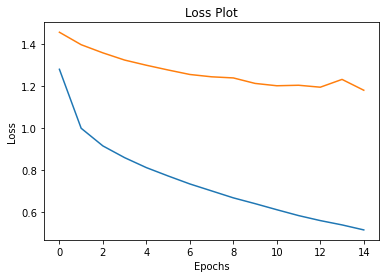

In [75]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [89]:
def evaluate(image):
    attention_plot = np.zeros((max_length, 64))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()#extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Plot attention

In [83]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [84]:
from nltk.translate.bleu_score import sentence_bleu

In [85]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

C:\Users\fairn\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\fairn\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\fairn\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

BELU score: 2.8688205803496793e-245
Real Caption: a dog jumps and runs through tall grass with an orange rope under its legs
Prediction Caption: a small leaps through a in not a woods


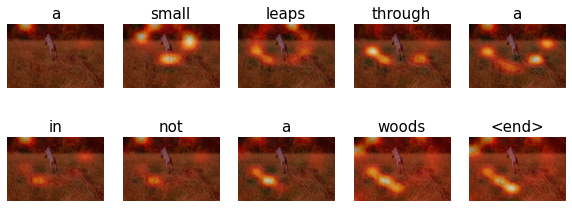

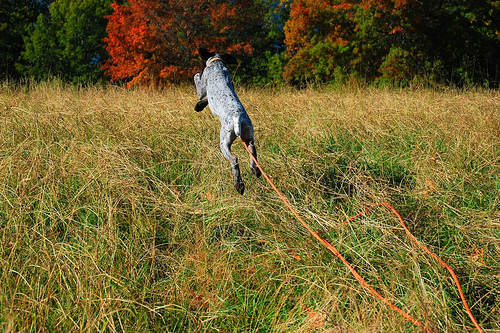

In [90]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      

pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
five_gm_weight = (1./5., 1./5., 1./5., 1./5., 1./5.)
score = sentence_bleu(reference, candidate, weights=five_gm_weight)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

### Beam Search(optional) - not implemented